<a href="https://colab.research.google.com/github/Alexis-CAPON/cse437-reinforcement-learning/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
def epsilon_greedy(state, epsilon):
  if random.random() < epsilon:
    return env.action_space.sample()
  else:
    return np.argmax(q_net(torch.FloatTensor(state).to(device)).detach().cpu().numpy())

In [ ]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
## MAIN Loop ###
rewards_dqn = []

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    state = next_state
    total_reward += reward
    train_dqn()

  print(f"Episode {episode + 1}, Total Reward: {total_reward}")
  rewards_dqn.append(total_reward)
  # Epsilon decaying
  epsilon = max(epsilon * epsilon_decay, epsilon_min)

Episode 1, Total Reward: -7842.0
Episode 2, Total Reward: -3945.0
Episode 3, Total Reward: -5830.0
Episode 4, Total Reward: -13022.0
Episode 5, Total Reward: -706.0
Episode 6, Total Reward: -2078.0
Episode 7, Total Reward: -4457.0
Episode 8, Total Reward: -1489.0
Episode 9, Total Reward: -1473.0
Episode 10, Total Reward: -1781.0
Episode 11, Total Reward: -1387.0
Episode 12, Total Reward: -2428.0
Episode 13, Total Reward: -2616.0
Episode 14, Total Reward: -1884.0
Episode 15, Total Reward: -2159.0
Episode 16, Total Reward: -4002.0
Episode 17, Total Reward: -1339.0
Episode 18, Total Reward: -826.0
Episode 19, Total Reward: -837.0
Episode 20, Total Reward: -1790.0
Episode 21, Total Reward: -2142.0
Episode 22, Total Reward: -1522.0
Episode 23, Total Reward: -1379.0
Episode 24, Total Reward: -1010.0
Episode 25, Total Reward: -668.0
Episode 26, Total Reward: -988.0
Episode 27, Total Reward: -1280.0
Episode 28, Total Reward: -844.0
Episode 29, Total Reward: -1373.0
Episode 30, Total Reward: -1

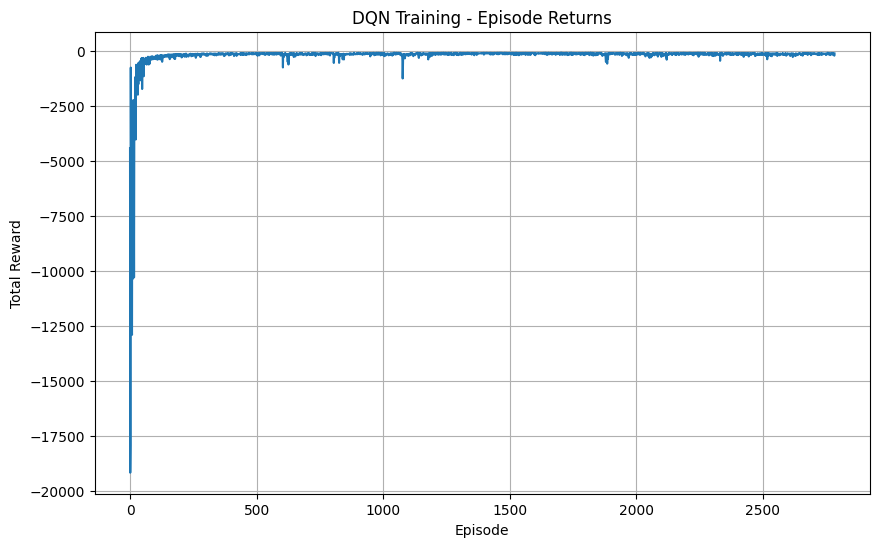

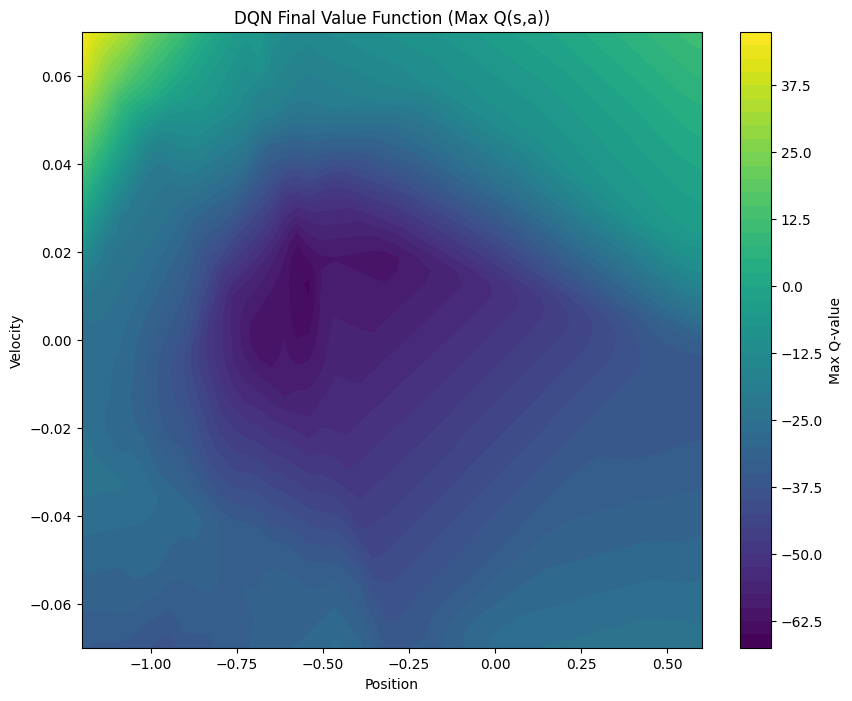

In [ ]:
# Plot Episode Returns
plt.figure(figsize=(10, 6))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training - Episode Returns")
plt.grid(True)
plt.show()

# Plot Final Value Function
# We can approximate the value function by taking the maximum Q-value for each state in a grid
position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)
velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 50)
value_function = np.zeros((len(position_space), len(velocity_space)))

for i, pos in enumerate(position_space):
    for j, vel in enumerate(velocity_space):
        state = np.array([pos, vel])
        with torch.no_grad():
            q_values = q_net(torch.FloatTensor(state).to(device))
            value_function[i, j] = torch.max(q_values).item()

plt.figure(figsize=(10, 8))
plt.contourf(position_space, velocity_space, value_function.T, levels=50, cmap='viridis')
plt.colorbar(label='Max Q-value')
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("DQN Final Value Function (Max Q(s,a))")
plt.show()

**Performance of your DQN agent:** How quickly does it learn? Does it reach the goal consistently?

Our DQN agent converge quickly, arround 20 episodes. The goal is quite consistent, the more we train.

**Comparison with tile coding:**
* Which representation learns faster?
In my case, the DQN agent converge faster only if we compare it to the default 8 dim and grid of the previous lab, if we fit the dim and the grid to find the "best", it converge faster than DQN

* Which one is more stable?
At the end, the DQN is more stable. It can be explain because of the structure. Tile would never be that precise that neurons, because tiles are approximation by griding. Even if we add dimension to have more features, it remain grids.

* How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
In my opinion, neural network by definition would be less able to generalize to new problems than linear with tiles, because the NN fit more the problem (when they are not overfitting), so if we start to change things, if will have trooble to adapt.

* Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
In my implementation, I use epislon decaying, so it's like auto tuning feature, that will enable to explore less with the time (with the hypothesis that we have converge to a good optimum before decreasing). So no, it's was less tuning compare to tiles because choosing the good dim and grid is tough.

**Insights:** What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)? With NN you loose easy explainibility, that could be a big problem like with autonomous vehicule to understand our a car will react based on a state. You need also a lot more training. And for tiles, you won't be able to be precise as the NN, it will be always a high approximation based on the grid if we don't want to overkill the compute with tiles.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [1]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409507 sha256=e3d7215ffaded4d5fead84007256a0776f3020ff05ed2019953dd7a2950f1b75
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.95
num_episodes = 2000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Q-Network
class QNetwork2(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork2, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)






In [3]:
def train_dqn():
      """Train the DQN using experience replay."""
      if len(replay_buffer) < batch_size:
          return
      batch = random.sample(replay_buffer, batch_size)
      states, actions, rewards, next_states, dones = zip(*batch)

      states = torch.FloatTensor(states).to(device)
      actions = torch.LongTensor(actions).to(device)
      rewards = torch.FloatTensor(rewards).to(device)
      next_states = torch.FloatTensor(next_states).to(device)
      dones = torch.FloatTensor(dones).to(device)

      q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
      next_q_values = q_net(next_states).max(1)[0].detach()
      targets = rewards + gamma * next_q_values * (1 - dones)

      loss = loss_fn(q_values, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

In [4]:
def epsilon_greedy(state, epsilon):
      if random.random() < epsilon:
        return env.action_space.sample()
      else:
        return np.argmax(q_net(torch.FloatTensor(state).to(device)).detach().cpu().numpy())

In [6]:
q_net = QNetwork2(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)
target_update_freq = 1
target_net = QNetwork2(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())


rewards_dqn = []

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False
  steps = 0


  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    state = next_state
    total_reward += reward
    train_dqn()

    steps = steps + 1
    if steps % target_update_freq == 0:
      target_net.load_state_dict(q_net.state_dict())


  print(f"Episode {episode + 1}, Total Reward: {total_reward}")
  rewards_dqn.append(total_reward)
  # Epsilon decaying
  epsilon = max(epsilon * epsilon_decay, epsilon_min)

Episode 1, Total Reward: -253.07737461605944
Episode 2, Total Reward: -317.58038092265883
Episode 3, Total Reward: -338.31678933550916
Episode 4, Total Reward: -193.79629020159638
Episode 5, Total Reward: -291.22382222717573
Episode 6, Total Reward: -142.20121802965602
Episode 7, Total Reward: -118.49662629634437
Episode 8, Total Reward: -199.10454788879676
Episode 9, Total Reward: -251.33530666990987
Episode 10, Total Reward: -48.461599395541995
Episode 11, Total Reward: -214.95321785754322
Episode 12, Total Reward: -166.5947775665261
Episode 13, Total Reward: -84.89553034488344
Episode 14, Total Reward: -220.98706540089353
Episode 15, Total Reward: -427.125626599674
Episode 16, Total Reward: -796.8294197849219
Episode 17, Total Reward: -560.1640883226863
Episode 18, Total Reward: -474.682641830754
Episode 19, Total Reward: -820.3578544815704
Episode 20, Total Reward: -723.2848633153843
Episode 21, Total Reward: -884.605133307913
Episode 22, Total Reward: -419.85769346846695
Episode 2

KeyboardInterrupt: 

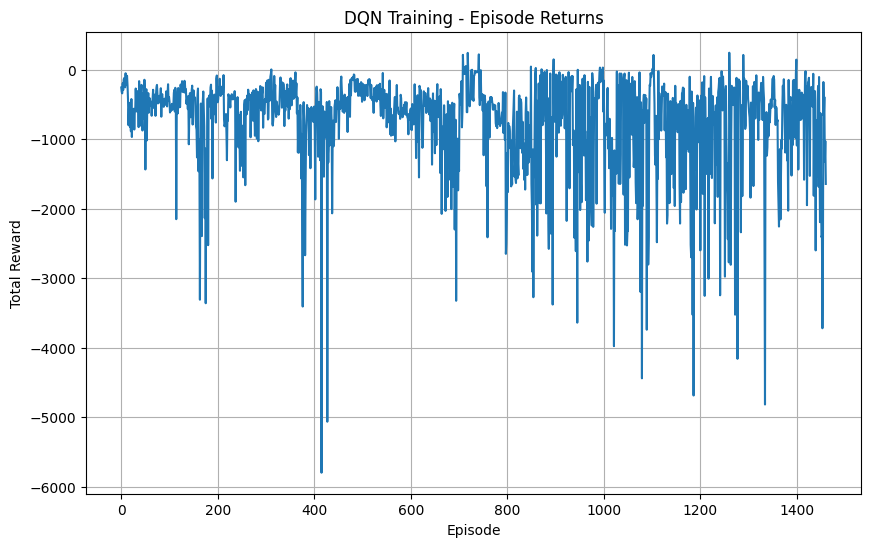

In [7]:
# Plot Episode Returns
plt.figure(figsize=(10, 6))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training - Episode Returns")
plt.grid(True)
plt.show()

# Plot Final Value Function
# We can approximate the value function by taking the maximum Q-value for each state in a grid
# For LunarLander, we can't easily plot the full 8-dimensional state space.
# Instead, let's plot the value function for a slice of the state space (e.g., position while keeping other state dimensions fixed).
# However, a more informative plot for LunarLander might be the episode returns.
# Let's stick to plotting the episode returns for now as it's more standard for higher-dimensional spaces.

# If you still want to visualize a slice of the value function, you would need to
# choose two dimensions to vary (e.g., position and velocity) and fix the others.
# For example, fixing other dimensions to their initial values or zeros.

# Example of plotting a 2D slice (Position and Velocity) - need to define fixed values for other 6 dimensions
# This is just an example and might not be the most informative slice.
# You would need to decide on appropriate fixed values.
# fixed_state_values = [0.0] * 6  # Example: fixing the other 6 state dimensions to 0

# position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)
# velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 50)
# value_function = np.zeros((len(position_space), len(velocity_space)))

# for i, pos in enumerate(position_space):
#     for j, vel in enumerate(velocity_space):
#         state = np.array([pos, vel] + fixed_state_values) # Combine varying and fixed values
#         with torch.no_grad():
#             q_values = q_net(torch.FloatTensor(state).to(device))
#             value_function[i, j] = torch.max(q_values).item()

# plt.figure(figsize=(10, 8))
# plt.contourf(position_space, velocity_space, value_function.T, levels=50, cmap='viridis')
# plt.colorbar(label='Max Q-value')
# plt.xlabel("Position")
# plt.ylabel("Velocity")
# plt.title("DQN Final Value Function Slice (Position and Velocity)")
# plt.show()

Did your agent learn to land consistently? In my case, not really, I needed to lower the update step to 1, because it was overfitting too much.
How many episodes did it take before you saw improvement? It didn't trained correctly, it diverge instead of converging

What effect did replay buffer size, target update frequency, and learning rate have on stability? If you increase target update frequency, you could be on a good way and then becaues you didn't updated, go completly on the other way.
Compare results across different runs (does it sometimes fail to converge?).
With an update frequency too large, it failed to converge correctly.



Compare this task with the MountainCar-v0 problem you solved earlier:

**What is extra or more challenging in LunarLander?**
We have more actions and more states. The reward system is also more complex. So at the end, more dimension and more complexity.

**Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?** Because it's need a lot more fine grained that just go to the top right, we need to go precisely, with more actions available. It become hard for simpler methods.
